# Исследование рынка компьютерных игр
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.



**Цель исследования**:
- Выявить определяющие успешность игры закономерности. 

 
**Таким образом, исследование пройдёт в несколько этапов:**
 1. Обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ данных
 4. Составление портрета пользователя каждого региона
 5. Проверка гипотез
 6. Формлировка общего вывода по выявленным закономерностям

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

### Откройте файл с данными и изучите общую информацию. 

In [2]:
try:
    games = pd.read_csv('/datasets/games.csv')
except:
    games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


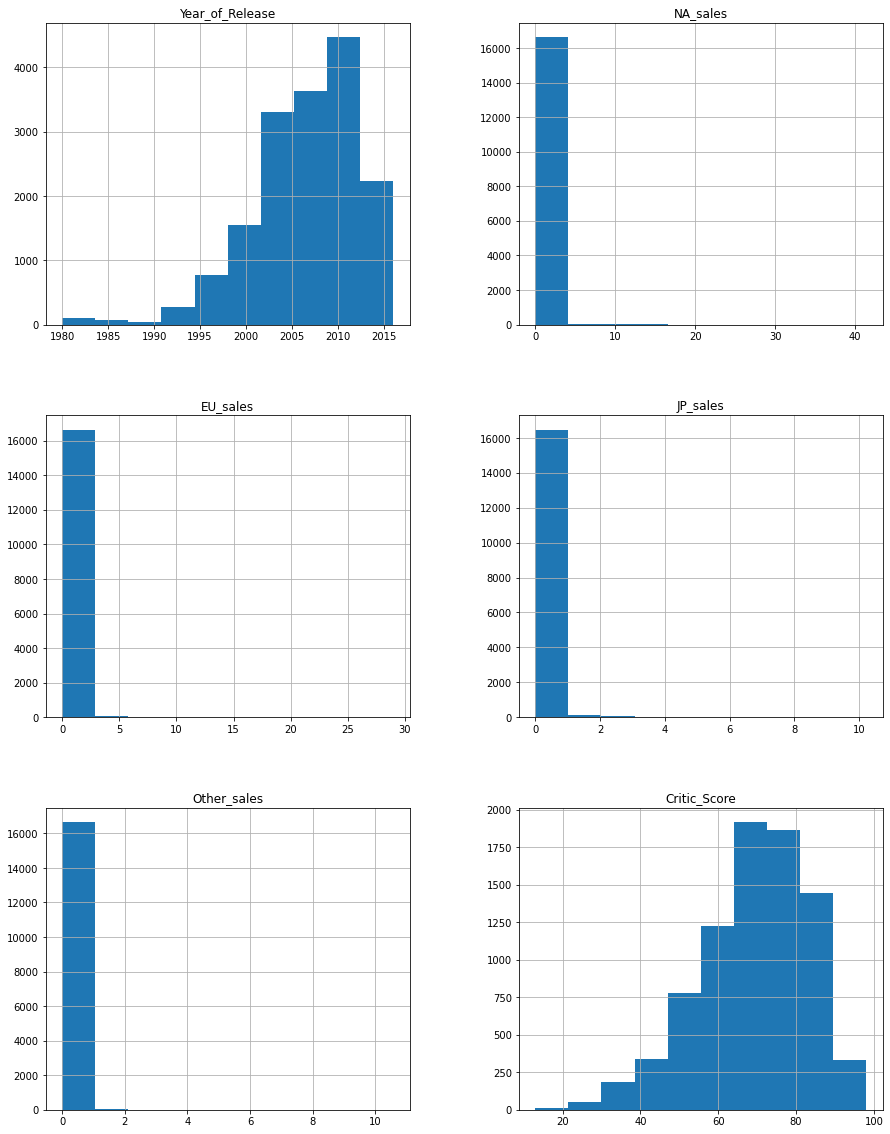

In [5]:
import matplotlib.pyplot as plt
games.hist(figsize=(15, 20))
plt.show();


По графикам можно понять какие данные нам поступили. Годы выпуска и оценки критиков нормально распределены, а количество продаж в разных регионах совпадает. Это хорошо

### Подготовьте данные

#### Обработка названий столбцов и значений

Приведем названия столбцов и значения строковых столбцов к нижнему регистру для удобства обращения с ними

In [6]:
games.columns = games.columns.str.lower()

In [7]:
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [8]:
games['name'] = games['name'].str.lower()
games['platform'] = games['platform'].str.lower()
games['genre'] = games['genre'].str.lower()

#### Обработка пропусков

In [9]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Проверим колличество пропусков в %

In [10]:
pd.DataFrame(round(games.isna().mean()*100).astype(int)).style.background_gradient('coolwarm')

,0
name,0
platform,0
year_of_release,2
genre,0
na_sales,0
eu_sales,0
jp_sales,0
other_sales,0
critic_score,51
user_score,40


**В многих столбцах есть пропущенные значения.** Рассмотрим каждый из них:
- name - строк с пропущенным именем всего 2, можем удалить эти строчки
- year_of_release - пропущенных значений всего 2% от общего числа, это скорее всего технический сбой, поэтому также можем удалить
- critic_score - заменить пропуски не получится
- user_score - заменить пропуски не получится
- rating - заменить пропуски не получится


Пропуски в столбцах с оценками и рейтингами могут быть обусловлены тем, что некоторые игры еще не оценили критики и пользователи (игра не вышла) или оценок недостаточно.

In [11]:
games = games.query('name.notna()')

In [12]:
games = games.query('year_of_release.notna()')

Обработаем значения 'tbd' в столбце с оценкой пользователей. Такое значение говорит о том, что игра еще не оценена. Заменим на NaN.

In [13]:
games['user_score'] = games['user_score'].where(games['user_score']!= 'tbd', np.nan).astype(float)

In [14]:
games['rating'] = games['rating'].fillna('tbd')

#### Изменение типов данных

Столбец с годом выпуска и оценками критиков имеют неверные типы. Значения в них должны быть целочисленными.  

In [15]:
games['year_of_release'] = games['year_of_release'].astype('Int64')
games['critic_score'] = games['critic_score'].astype('Int64')

#### Посчитаем суммарные продажи

In [16]:
games['all_sales'] = games['na_sales']+games['eu_sales']+games['jp_sales']+games['other_sales']

#### Обработка неявных дубликатов

In [17]:
games['genre'].unique()

array(['sports', 'platform', 'racing', 'role-playing', 'puzzle', 'misc',
       'shooter', 'simulation', 'action', 'fighting', 'adventure',
       'strategy'], dtype=object)

Неявных дубликатов нет

#### Обработка явных дубликатов

In [18]:
games.duplicated().sum()

0

Явных дубликатов нет. Это хорошо.

#### Обработка аномальных значений

<AxesSubplot:>

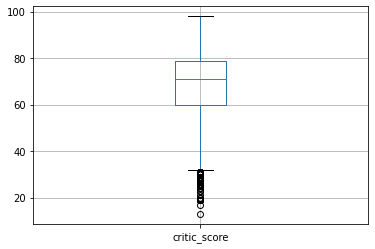

In [19]:
games[['critic_score']].boxplot()

<AxesSubplot:>

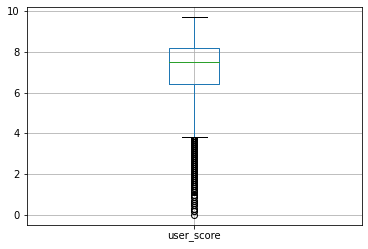

In [20]:
games[['user_score']].boxplot()

Оценка критиков не может превышать 100, в данных этого столбца нет значений, противоречащих этому условию. 
Оценка пользователей не может превышать 10, в данных этого столбца нет значений, противоречащих этому условию. 

### Проведите исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы

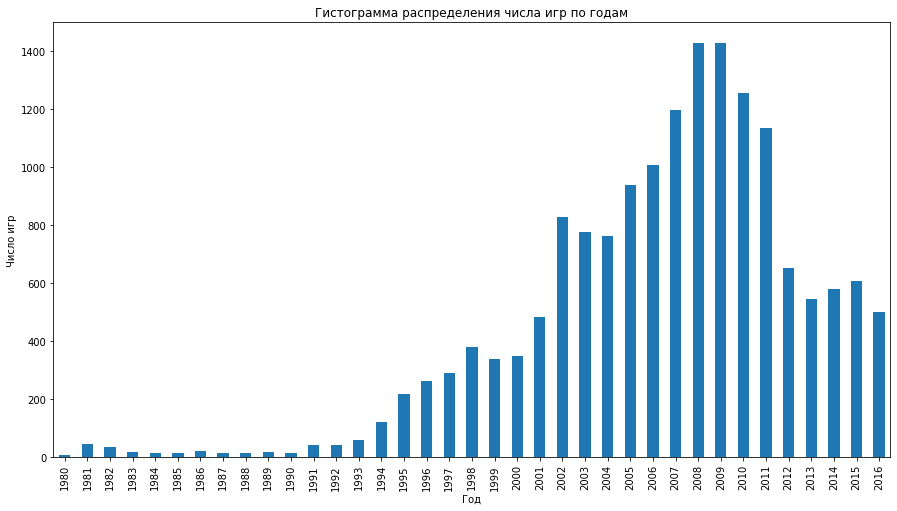

In [21]:
games.groupby('year_of_release').count()['name'].plot(kind = 'bar', figsize=(15,8))
plt.title('Гистограмма распределения числа игр по годам')
plt.xlabel('Год')
plt.ylabel('Число игр')
plt.show()

По графику видно, что до 1991 года игр выпускалось очень мало, эти данные не так важны. А самый пик производства игр был в 2008-2009.

Посмотрим как менялись продажи по платформам

Общее число проданных игр по платформам

In [22]:
top_platforms = games.groupby('platform')['all_sales'].sum().sort_values(ascending = False).head(10).reset_index()
top_platforms

,platform,all_sales
0,ps2,1233.56
1,x360,961.24
2,ps3,931.34
3,wii,891.18
4,ds,802.78
5,ps,727.58
6,ps4,314.14
7,gba,312.88
8,psp,289.53
9,3ds,257.81


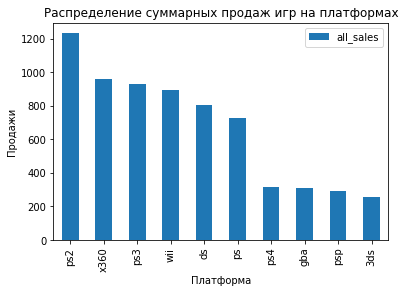

In [23]:
top_platforms.plot(x = 'platform', y = 'all_sales', kind = 'bar')
plt.title('Распределение суммарных продаж игр на платформах')
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.show()


Самые большие продажи за все время у ps2, x360 и ps3, это может быть обусловлено тем, что эти платформы были "прорывом" в свое время и довольно долго на рынке, но они до сих пор поддерживают некоторые новые игры

Посмотрим распределение по годам

In [24]:
top_platforms_index = games.groupby('platform')['all_sales'].sum().sort_values(ascending = False).head(10).index

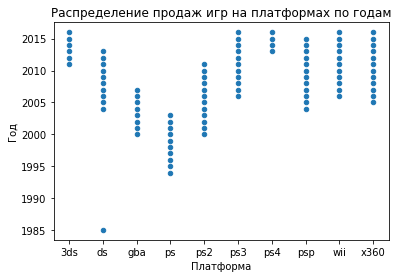

In [25]:
(games
 .query('platform in @top_platforms_index')
 .pivot_table(index=['platform', 'year_of_release'], values='all_sales', aggfunc='sum')
 .reset_index()
 .plot(x='platform', y='year_of_release', kind='scatter', alpha=1));
plt.title('Распределение продаж игр на платформах по годам')
plt.xlabel('Платформа')
plt.ylabel('Год')
plt.show()


Заметим, что на платформе ds есть выброс в 1985 году. Удалим его.

In [26]:
games = games.query('platform!="ds" or year_of_release!=1985')

Число игр резко росло с 2000 года, а в 2012 число игр сократилось. Игры стали качественнее и сложнее, их создают крупные разработчики, поэтому число снизилось. 

Мы рассмотрели суммарные продажи числа игр на разных платформах по годам и можно сделать вывод, что срок жизни платформ составляет около 10 лет.

Можно выделить актуальный период для исследования - данные после 2013 года. 

In [27]:
games_actual = games.query('year_of_release>2012')

In [28]:
data_actual_index =games.groupby('platform')['all_sales'].sum().sort_values(ascending = False).index

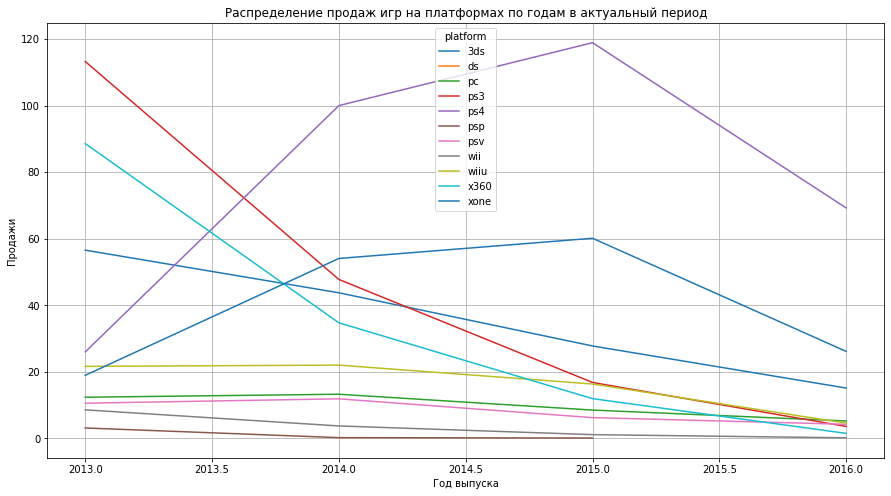

In [29]:
(games_actual
 .query('platform in @data_actual_index')
 .pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')
 .plot(grid=True, figsize=(15,8)));
plt.title('Распределение продаж игр на платформах по годам в актуальный период')
plt.xlabel('Год выпуска')
plt.ylabel('Продажи')
plt.show()

По графикам можно сказать, что сейчас продажи платформ падают. По продажам в последний год лидируют ps4, 3ds, xone. 

In [30]:
games_dynamix = games_actual.groupby(['platform','year_of_release']).sum().reset_index()

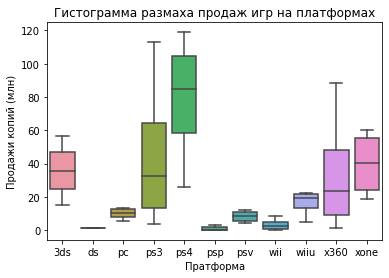

In [31]:
sns.boxplot(data = games_dynamix, x = 'platform', y ='all_sales')
plt.title('Гистограмма размаха продаж игр на платформах')
plt.xlabel('Пратформа')
plt.ylabel('Продажи копий (млн)')
plt.show()

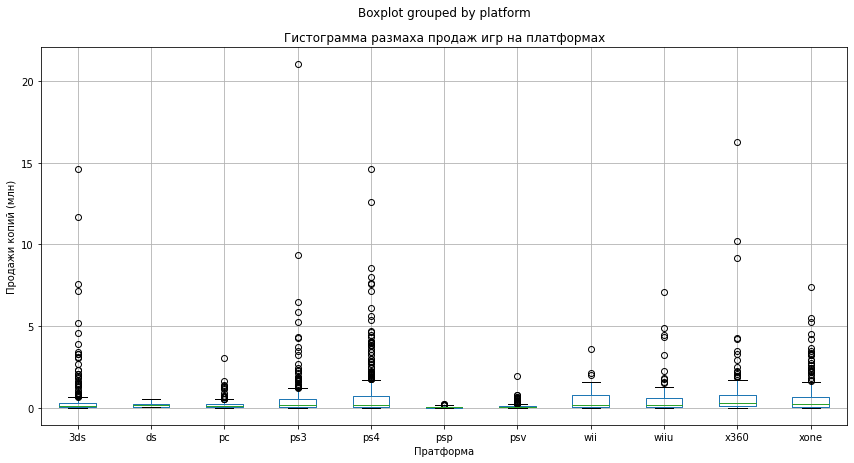

In [32]:
games_actual.boxplot( column="all_sales", by="platform", figsize=(14, 7), grid=True)
plt.title('Гистограмма размаха продаж игр на платформах')
plt.xlabel('Пратформа')
plt.ylabel('Продажи копий (млн)')
plt.show()

Ps4 - самая потенциально прибыльная платформа с наибольшим числом продаж за последний год, потом 3ds, платформа xone также имеет довольно большие продажи за посление годы.

Разница в показателях между платформами достигается из-за эксклюзивности игр на платформах. Портативные системы(3ds, ds, psp, wii, psv, wiiu) становятся не актуальны.

На боксплоте можно заметить выбросы в продажах игр на платформах ps3, x360, это можно объяснить тем, что эти платформы были очень успешны в свое время и их пользователи до сих пор пользуются ими и покупают игры. 

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Создадим функцию, которая строит диаграмму рассеяния и считает корреляцию между отзывами и продажами.

In [33]:
def plot_corr_platform(df):
    df.plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.4)
    plt.title('Диаграмма рассеяния продаж от оценки критиков')
    plt.xlabel('Оценка критиков')
    plt.ylabel('Продажи (млн)')
    plt.show()
    df.plot(x='user_score', y='all_sales', kind='scatter', alpha=0.4)
    plt.title('Диаграмма рассеяния продаж от оценки пользователей')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи (млн)')
    plt.show()
    return df.corr()[['critic_score','user_score']].loc['all_sales']

In [34]:
ps3 = games.query('platform == "ps3"')
ps4 = games.query('platform == "ps4"')
threeds = games.query('platform == "3ds"')
xone = games.query('platform == "xone"')

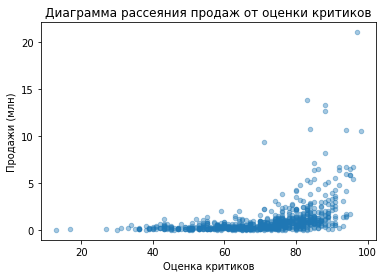

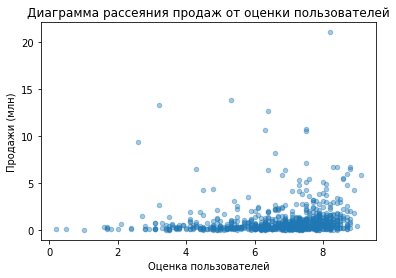

critic_score    0.432759
user_score      0.128416
Name: all_sales, dtype: float64

In [35]:
plot_corr_platform(ps3)

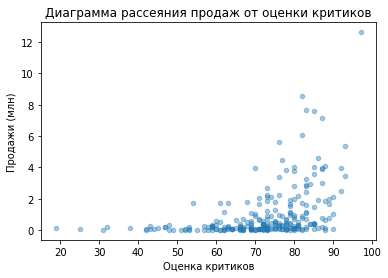

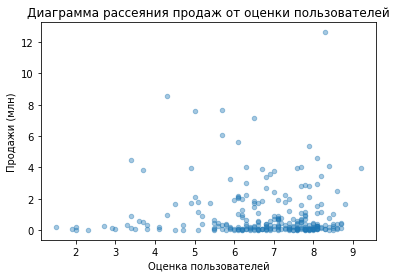

critic_score    0.406568
user_score     -0.031957
Name: all_sales, dtype: float64

In [36]:
plot_corr_platform(ps4)

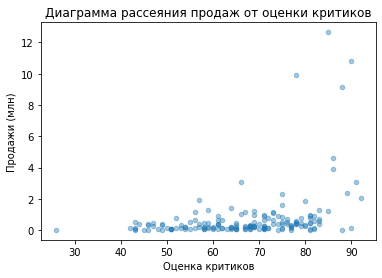

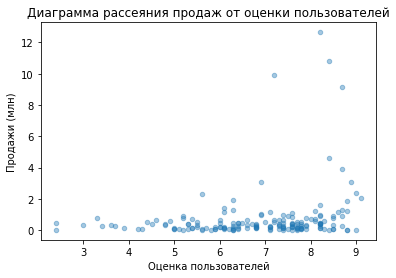

critic_score    0.348740
user_score      0.222078
Name: all_sales, dtype: float64

In [37]:
plot_corr_platform(threeds)

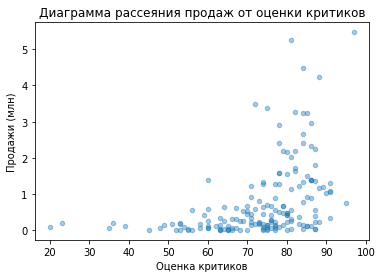

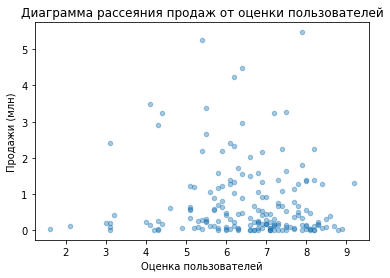

critic_score    0.416998
user_score     -0.068925
Name: all_sales, dtype: float64

In [38]:
plot_corr_platform(xone)

По диаграмме рассеяния видим, что до 70 баллов оценок критиков число продаж низкое, от 70 начинается рост.

И по коэффициенту корреляции можем сделать вывод, что небольшая связь между оценками критиков и продажами есть, а связь между оценками пользователей и продажами отсутствует, тк оценка пользователей появляется сильно позже релиза игры.

Посмотрим на общее распределение игр по жанрам.

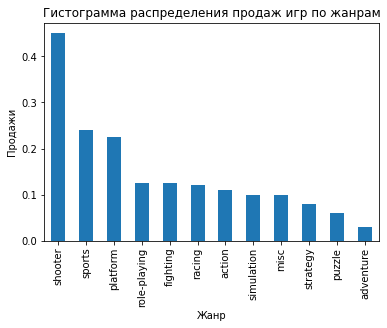

In [39]:
games_actual.groupby('genre')['all_sales'].median().sort_values(ascending=False).plot(kind='bar')
plt.title('Гистограмма распределения продаж игр по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.show()

По графику можно сказать, что жанры, где игры стабильно приносят высокий доход в последние годы - это shooter, sports и platform

**Вывод:** до 1991 года игр выпускалось очень мало, а самый пик производства игр был в 2008-2009, в 2012 число игр сократилось. Игры стали качественнее и сложнее, их создают крупные разработчики, поэтому число снизилось. Резкий спад популярности платформы может произойти за 3-4 года.

Ps4 - самая потенциально прибыльная платформа с наибольшим числом продаж за последний год, потом 3ds, платформа xone также имеет довольно большие продажи за посление годы.

Разница в показателях между платформами достигается из-за эксклюзивности игр на платформах. Портативные системы(ds, psp, wii, psv, wiiu) становятся не актуальны.

Можно заметить выбросы в продажах игр на платформах ps3, x360, это можно объяснить тем, что эти платформы были очень успешны в свое время и их пользователи до сих пор пользуются ими и покупают игры. 

по коэффициенту корреляции можем сделать вывод, что связь между оценками критиков и продажами есть, а связь между оценками пользователей и продажами отсутствует.

Жанры, где игры стабильно приносят высокий доход в последние годы - это shooter, sports и platform

###  Составьте портрет пользователя каждого региона

Определим для пользователей каждого региона cамые популярные платформы (топ-5)

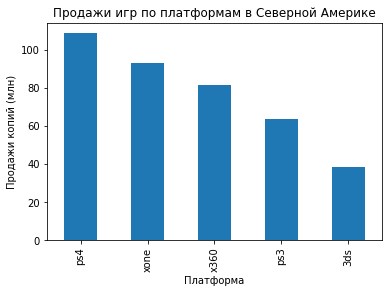

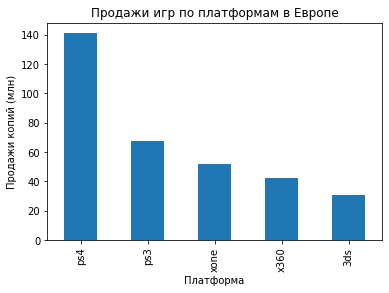

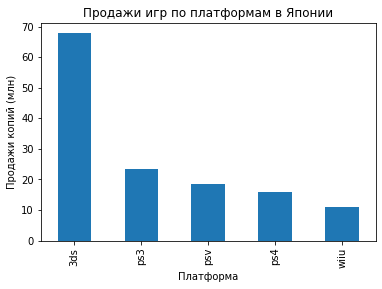

In [40]:
region = ['na_sales', 'eu_sales', 'jp_sales']
title = ['Северной Америке', 'Европе', 'Японии']
for i in range(3):
    games_actual.groupby('platform').sum()[region[i]].sort_values(ascending = False).head().plot(kind = 'bar')
    plt.title('Продажи игр по платформам в {}'.format(title[i]))
    plt.xlabel('Платформа')
    plt.ylabel('Продажи копий (млн)')
    plt.show()

В Европе и в Северной Америке самой популярной платформой является ps4, а в Японии - 3ds, портативная игровая система местного производства. Это различие обусловлено сильным различием культур регионов. 

Самые популярные жанры (топ-5)

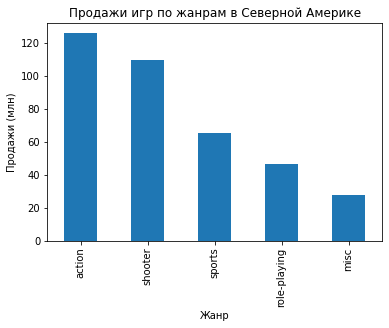

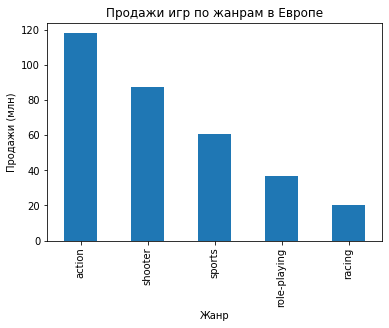

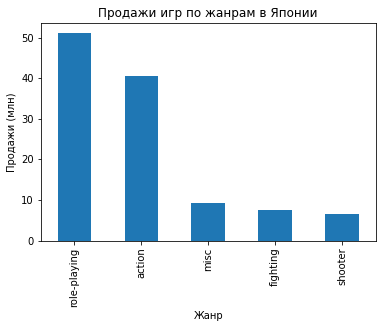

In [41]:
region = ['na_sales', 'eu_sales', 'jp_sales']
title = ['Северной Америке', 'Европе', 'Японии']
for i in range(3):
    games_actual.groupby('genre').sum()[region[i]].sort_values(ascending = False).head().plot(kind = 'bar')
    plt.title('Продажи игр по жанрам в {}'.format(title[i]))
    plt.xlabel('Жанр')
    plt.ylabel('Продажи (млн)')
    plt.show()

В Японии самый популярный жанр игры - role-playing, в то время как в Европе и Америке - action.

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

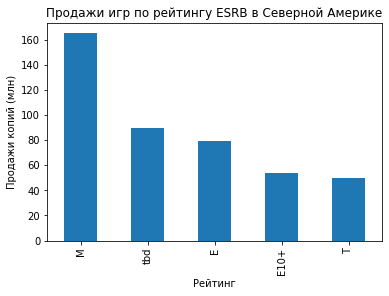

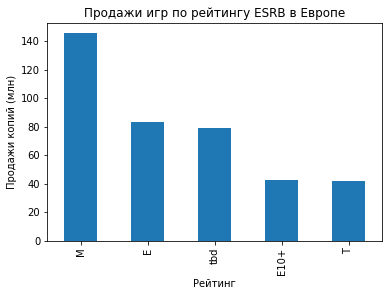

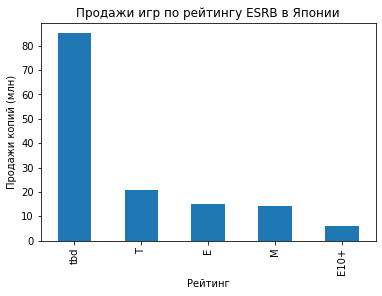

In [42]:
region = ['na_sales', 'eu_sales', 'jp_sales']
title = ['Северной Америке', 'Европе', 'Японии']
for i in range(3):
    games_actual.groupby('rating').sum()[region[i]].sort_values(ascending = False).head().plot(kind = 'bar')
    plt.title('Продажи игр по рейтингу ESRB в {}'.format(title[i]))
    plt.xlabel('Рейтинг')
    plt.ylabel('Продажи копий (млн)')
    plt.show()

**Вывод:**
В Северной Америке самой популярной платформой является x360, наиболее продаваемые жанры action и shooter, рейтинг M(для взрослых). 

В Европе наибольшее число продаж у платформы ps4 (ps3 на втором месте), предпочтения жанров и рейтингов те же(action, shooter, рейтинг M).

В Японии с большим отрывом лидирует платформа 3ds, наиболее популярные жанры role-playing и action. Для Японии производится множество локальных игр, рейтинг для которых не присваивается ESRB, и мы не можем явно определить лидирующие жанры.

###  Проверьте гипотезы

Проверим гипотезу - cредние пользовательские рейтинги платформ Xbox One и PC одинаковые - H0

Гипотеза H1 - cредние пользовательские рейтинги платформ Xbox One и PC различается 

Проверим гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам применим метод scipy.stats.ttest_ind()

In [43]:
games_user = games_actual.query('user_score.notna()')
xbox = games_user.query('platform == "xone"')
pc = games_user.query('platform == "pc"')

In [44]:
disp1 = np.var(xbox['user_score'])
disp2 = np.var(pc['user_score'])
print(disp1, disp2)

1.8965188383045526 3.016306347554631


Дисперсии выборок отличаются на 1, укажем equal_var = False

In [45]:
results = st.ttest_ind(xbox['user_score'], pc['user_score'], equal_var = False)
print('p-значение: ', results.pvalue)

p-значение:  0.14759594013430463


**Вывод:** При уровне значимости p = 0.05, гипоеза H0 о равенстве cредних пользовательских рейтингах платформ Xbox One и PC не отвергается. 

Проверим гипотезу - средние пользовательские рейтинги жанров Action и Sports равны - H0

Гипотеза H1 -средние пользовательские рейтинги жанров Action и Sports различны



In [46]:
action = games_user.query('genre == "action"')
sports= games_user.query('genre == "sports"')

In [47]:
disp1 = np.var(action['user_score'])
disp2 = np.var(sports['user_score'])
print(disp1, disp2)

1.7648124186332366 3.160733984375


Дисперсии выборок существенно отличаются, укажем equal_var = False

In [48]:
results = st.ttest_ind(action['user_score'], sports['user_score'], equal_var = False)
print('p-значение: ', results.pvalue)

p-значение:  1.4460039700704315e-20


**Вывод:** Гипотеза H0 о равенстве средних пользовательских рейтингов жанров Action и Sports отвергается и принимается альтернативная гипотеза H1 - средние пользовательские рейтинги жанров Action и Sports различны.

### Напишите общий вывод

Мы исследовали исторические данные о продажах игр, оценках пользователей и экспертов, жанрах и платформах.
Изучив общую информацию, выяснили, что в данных присутствуют пропуски. Множество пропусков в столбцах с оценками и рейтингом. Возможно, что некоторые игры еще не оценили критики и пользователи (игра не вышла). Мы подготовили данные и приступили к исследовательскому анализу данных.

- до 1991 года игр выпускалось очень мало, а самый пик производства игр был в 2008-2009, в 2012 число выпускаемых игр сократилось. Игры стали качественнее и сложнее, их создают крупные разработчики, поэтому число снизилось.

- Резкий спад популярности платформы может произойти за 3-4 года.

- По продажам в последние годы лидируют ps4, 3ds, xone

- Ps4 - самая потенциально прибыльная платформа с наибольшим числом продаж за последний год, потом 3ds, платформа xone также имеет довольно большие продажи за посление годы.

- Разница в показателях между платформами достигается из-за эксклюзивности игр на платформах. Портативные системы(ds, psp, wii, psv, wiiu) становятся не актуальны.

- по коэффициенту корреляции можем сделать вывод, что связь между оценками критиков и продажами есть, а связь между оценками пользователей и продажами отсутствует.

- Жанры, где игры стабильно приносят высокий доход в последние годы - это shooter, sports и platform

- В Северной Америке самой популярной платформой является ps4, наиболее продаваемые жанры action и shooter, рейтинг M(для взрослых).

- В Европе наибольшее число продаж у платформы ps4, предпочтения жанров и рейтингов те же(action, shooter, рейтинг M).

- В Японии с большим отрывом лидирует платформа 3ds, наиболее популярные жанры role-playing и action. Для Японии производится множество локальных игр, рейтинг для которых не присваивается ESRB, и мы не можем явно определить лидирующие жанры.

Мы выдвинули и проверили гипотезы. 

- Гипоеза о равенстве cредних пользовательских рейтингах платформ Xbox One и PC не отвергается. 

- Гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports отвергается, принимается альтернативная гипотеза H1 - средние пользовательские рейтинги жанров Action и Sports различны.

